starting by importing libraries

In [25]:
import os
import pandas as pd
import numpy as np
from GoogleNews import GoogleNews
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from os import path
from nltk.corpus import stopwords
from textblob import TextBlob
import statsmodels.api as sm
from scipy import stats
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from scipy.stats import shapiro
import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment analysis on Headlines from different media sources for Ireland, USA and UK

#### Data gathering

In order to extract headlines I'm going to use a library called GoogleNews
https://pypi.org/project/GoogleNews/

license here:
https://github.com/Iceloof/GoogleNews/blob/master/LICENSE

the .get_news() method from the GoogleNews library will return the first 100 results for article titles in google news for a specific search:

the argument selected are:

1. the search terms: "Housing Ireland" "Housing UK" "Housing USA"
2. a specific period 

My research is interested in identyfing trends over the previous 10 years so the function will loop through different periods of 6 months lenght and return the first 100 results for that specific period and search terms.

The data is then collected in a pandas dataframe.

In [26]:
#time dictionary for function

dict_time = {'06/01/2020' : '12/31/2020',
             '06/01/2021' : '12/31/2021',
             '06/01/2022' : '12/31/2022',
             '06/01/2023' : '12/31/2023',
             '06/01/2019' : '12/31/2019',
             '06/01/2018' : '12/31/2018',
             '06/01/2017' : '12/31/2017',
             '06/01/2016' : '12/31/2016',
             '06/01/2015' : '12/31/2015',
             '06/01/2014' : '12/31/2014',
             '01/01/2020' : '06/01/2020',
             '01/01/2021' : '06/01/2021',
             '01/01/2022' : '06/01/2022',
             '01/01/2023' : '06/01/2023',
             '01/01/2019' : '06/01/2019',
             '01/01/2018' : '06/01/2018',
             '01/01/2017' : '06/01/2017',
             '01/01/2016' : '06/01/2016',
             '01/01/2015' : '06/01/2015',
             '01/01/2014' : '06/01/2014'}

#creating function

def search_gn(s):
  df_final = pd.DataFrame()
  for x in dict_time:
    googlenews = GoogleNews(start=x,end=dict_time[x])
    googlenews.get_news(s)
    googlenews.enableException(True)
    result_FINAL = googlenews.result(sort=True)
    df_n = pd.DataFrame(result_FINAL)
    df_n['year'] = dict_time[x]
    df_n['year']= df_n['year'].str[-4:]
    df_final = df_final.append(df_n)
    
  return df_final

In [28]:
#applying function for 3 different search (UK, USA, Ireland)

Ireland = search_gn('Housing Ireland') 
Uk = search_gn('Housing UK') 
USA = search_gn('Housing USA') 

#function usually takes around 3/4 min to run 
# if error "< not supported..." please run again this cell - it was an open issue on googlenews github page at the time of this code

Data cleaning and transformation on Article dataset:

1. Dropping duplicates
2. inserting Country label
3. creating one big final dataset
4. checking null values
5. eliminating null/useless attributes

Why dropping duplicates?

possible reasons of duplication:

1. as we are looping through different periods The same Article might be present in more than 1 loop if for example it has been republished more than 1 time in a year
2. because of Google Search engine optimization techniques an article might be picked up multiple times as considered relevant by Google news in different periods

In [29]:
#dropping ducplicates 

_Ireland = Ireland.drop_duplicates()
_Uk = Uk.drop_duplicates()
_USA = USA.drop_duplicates()

# Adding label to datasets

_Ireland['Country'] = 'Eire'
_Uk['Country'] = 'UK'
_USA['Country'] = 'USA'

In [30]:
#concatenating into final dataset

frames = [_Ireland,_USA,_Uk]
Headlines = pd.concat(frames)
Headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5543 entries, 0 to 99
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     5543 non-null   object        
 1   desc      0 non-null      object        
 2   date      5543 non-null   object        
 3   datetime  5543 non-null   datetime64[ns]
 4   link      5543 non-null   object        
 5   img       5543 non-null   object        
 6   media     5543 non-null   object        
 7   site      0 non-null      object        
 8   year      5543 non-null   object        
 9   Country   5543 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 476.4+ KB


In [31]:
Headlines.head()

,title,desc,date,datetime,link,img,media,site,year,Country
0,Thurles Lions Trust look to the future of hous...,None,19 minutes ago,2023-05-26 19:48:55.378506,news.google.com/./articles/CBMigwFodHRwczovL3d...,https://lh3.googleusercontent.com/PlVnT3_wbPIK...,Tipperary Live,None,2020,Eire
1,Council of Europe commissioner raises concerns...,None,1 hour ago,2023-05-26 19:07:55.375502,news.google.com/./articles/CBMimAFodHRwczovL3d...,https://lh3.googleusercontent.com/SdqfETkyt1XH...,The Irish Times,None,2020,Eire
2,Leo Varadkar 'to implement necessary measures'...,None,1 hour ago,2023-05-26 19:07:55.369506,news.google.com/./articles/CBMimgFodHRwczovL3d...,https://lh3.googleusercontent.com/kTyLj7syU8e5...,Independent.ie,None,2020,Eire
3,Numbers in emergency accommodation surpasses 1...,None,2 hours ago,2023-05-26 18:07:55.367521,news.google.com/./articles/CBMiSmh0dHBzOi8vd3d...,https://lh3.googleusercontent.com/proxy/kQPmvl...,RTE.ie,None,2020,Eire
4,Conference to kickstart conversation on housin...,None,4 hours ago,2023-05-26 16:07:55.386746,news.google.com/./articles/CBMiemh0dHBzOi8vd3d...,https://lh3.googleusercontent.com/ounfP8uqhjXu...,NorthernIrelandWorld,None,2020,Eire


#### SAVING DATA INTO MYSQL DATABASE

Since the gathering operation might be time consuming I decided to store the resuls in a SQL database (and in a csv file as backup) so that there's no need to run the code everytime, especially helpful for debugging and testing reason

In [32]:
#saving as csv as backup
Headlines = Headlines[['title','media','year','Country']]
Headlines.to_csv('C:\\Users\\santi\\OneDrive\\Desktop\\CA\\backup.csv')

Connecting to MYSQL Server

In [33]:
import mysql.connector

host="localhost" # "127.0.0.1"
user="root" # root
password="Dublino1@" # root password

Creating the database in SQL by doing a bulk insert for the data we are interested in (title, media, year, country )

problem: apostrophe in the data might collide with the SQL synthax

example : INSERT INTO News (_title, _media, _year, _country) 
           VALUES ('2022', 'Ireland', 'Irish Examiner', ' O'<font color='red'>Hara said we should build more houses')</font>


by replacing " ' " with space we should be ready to go

In [34]:
#creating cursor
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    port = 3306
)
conn = db.cursor()

# first statements
conn.execute('DROP DATABASE IF EXISTS  Newspaper;')          #in case there's already a DB with the same name
conn.execute('CREATE DATABASE IF NOT EXISTS Newspaper;')
conn.execute('USE Newspaper;')
conn.execute('CREATE TABLE IF NOT EXISTS News (              _title VARCHAR(255),   _media VARCHAR(255),   _year INT,   _country VARCHAR(255)           );')

#removing " ' " from title and media

Headlines['title'] = Headlines['title'].str.replace("'", ' ')
Headlines['media'] = Headlines['media'].str.replace("'", ' ')

# iterating through dataset to get values to be inserted row by row 

lst = [(row['title'], row['media'],  row['year'], row['Country']) for i, row in Headlines.iterrows()]
print(lst)

#main query
query  = ' INSERT INTO News (_title, _media, _year, _country) VALUES (%s, %s,%s, %s); '

#execute many (thanks Sam)
conn.executemany(query,lst)

db.commit()

#exporting data from the SQL database
query_2 = "Select * from News;"
headlines = pd.read_sql(query_2,db)

#closing cursor for good measure
conn.close()
db.close()


[('Thurles Lions Trust look to the future of housing at Stanwix Village ...', 'Tipperary Live', '2020', 'Eire'), ('Council of Europe commissioner raises concerns over ...', 'The Irish Times', '2020', 'Eire'), ('Leo Varadkar  to implement necessary measures  for international ...', 'Independent.ie', '2020', 'Eire'), ('Numbers in emergency accommodation surpasses 12,000', 'RTE.ie', '2020', 'Eire'), ('Conference to kickstart conversation on housing across Mid Ulster', 'NorthernIrelandWorld', '2020', 'Eire'), ('Three rescued from fire at retirement housing complex in north Belfast', 'Belfast Telegraph', '2020', 'Eire'), ('Number in emergency accommodation rises above 12,000 for first time', 'BreakingNews.ie', '2020', 'Eire'), ('Number of homeless people tops 12,000 for first time ever in month after eviction ban lifted', 'Irish Examiner', '2020', 'Eire'), ('Housing crisis Ireland: Homelessness figures break 12,000 for first time as eviction ban dropped', 'Buzz.ie', '2020', 'Eire'), ('Homel

Now that the Data gathering, cleaning and transformation has been done we can start with the sentiment analysis

In [35]:
#extracting data from SQL

db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    port = 3306
)

conn = db.cursor()
conn.execute('USE Newspaper;')
query_2 = "Select * from News;"
headlines = pd.read_sql(query_2,db)

headlines.head()

,_title,_media,_year,_country
0,Thurles Lions Trust look to the future of hous...,Tipperary Live,2020,Eire
1,Council of Europe commissioner raises concerns...,The Irish Times,2020,Eire
2,Leo Varadkar to implement necessary measures ...,Independent.ie,2020,Eire
3,Numbers in emergency accommodation surpasses 1...,RTE.ie,2020,Eire
4,Conference to kickstart conversation on housin...,NorthernIrelandWorld,2020,Eire


In [36]:
#reset columns name
headlines = headlines.set_axis(['title', 'media', 'year', 'Country'], axis=1, inplace=False)

In [37]:
#checking nulls
headlines.isna().sum()

title      0
media      0
year       0
Country    0
dtype: int64

plotting number of articles by media

Text(0.5, 1.0, 'Number of articles by newspaper')

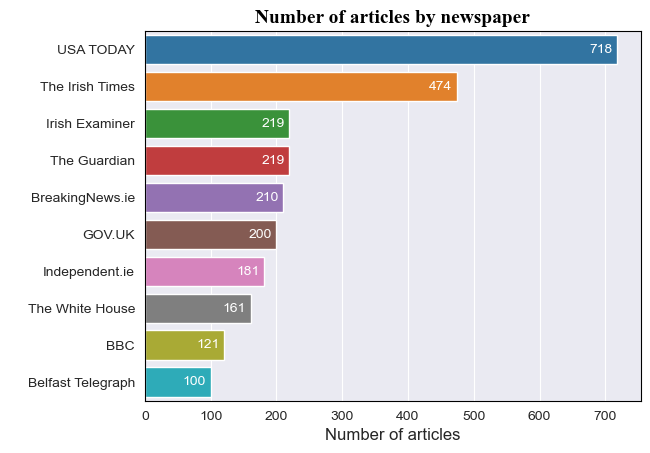

In [38]:
custom = {"axes.edgecolor": "black", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)
ax = sns.countplot(y=headlines["media"], order=headlines.media.value_counts().iloc[:10].index)
ax.bar_label(ax.containers[0], padding=-20, color='white', fontsize=10)
headlines["media"].unique()
ax.set_xlabel("Number of articles",fontsize=12)
ax.set_ylabel(" ")
ax.set_title("Number of articles by newspaper",fontsize=14,color= "black", weight='bold',fontname="Times New Roman")

Number of articles by country and year

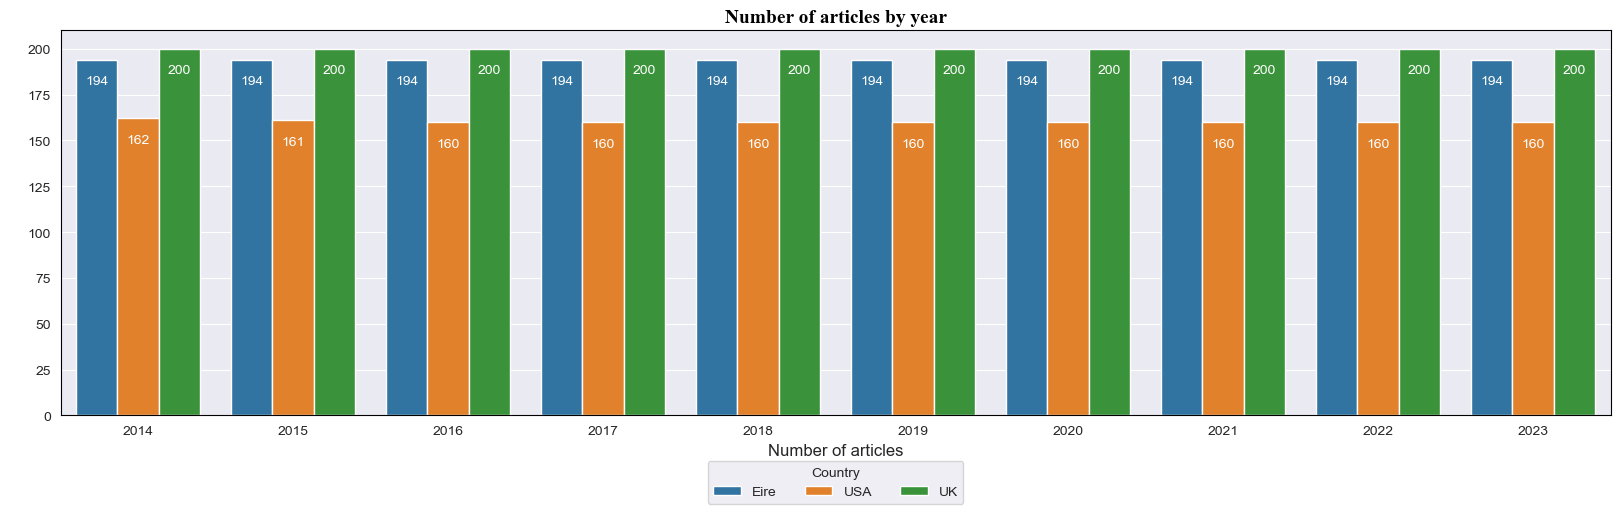

In [39]:
plt.rc('figure', figsize=(20, 5))
ax = sns.countplot(x=headlines["year"], hue=headlines['Country'])
for x in range(3):
    ax.bar_label(ax.containers[x], padding=-20, color='white', fontsize=10)
    
# Set label colors
label_colors = {'Eire': 'green', 'USA': 'orange', 'UK': 'blue'}
for label in ax.get_legend().get_texts():
    country = label.get_text()
    if country in label_colors:
        label.set_color(label_colors[country])

ax.set_xlabel("Number of articles", fontsize=12)
ax.set_ylabel(" ")
ax.set_title("Number of articles by year", fontsize=14, color="black", weight='bold', fontname="Times New Roman")

# Move legend to top and center
ax.legend(title="Country", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()




Using text blob to assign a polarity score to each title

In [40]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity  #there's also subjectivity if we want
    except:
        return None

headlines['polarity'] = headlines['title'].apply(sentiment_calc)

plotting polarity by country

<AxesSubplot:xlabel='Country', ylabel='polarity'>

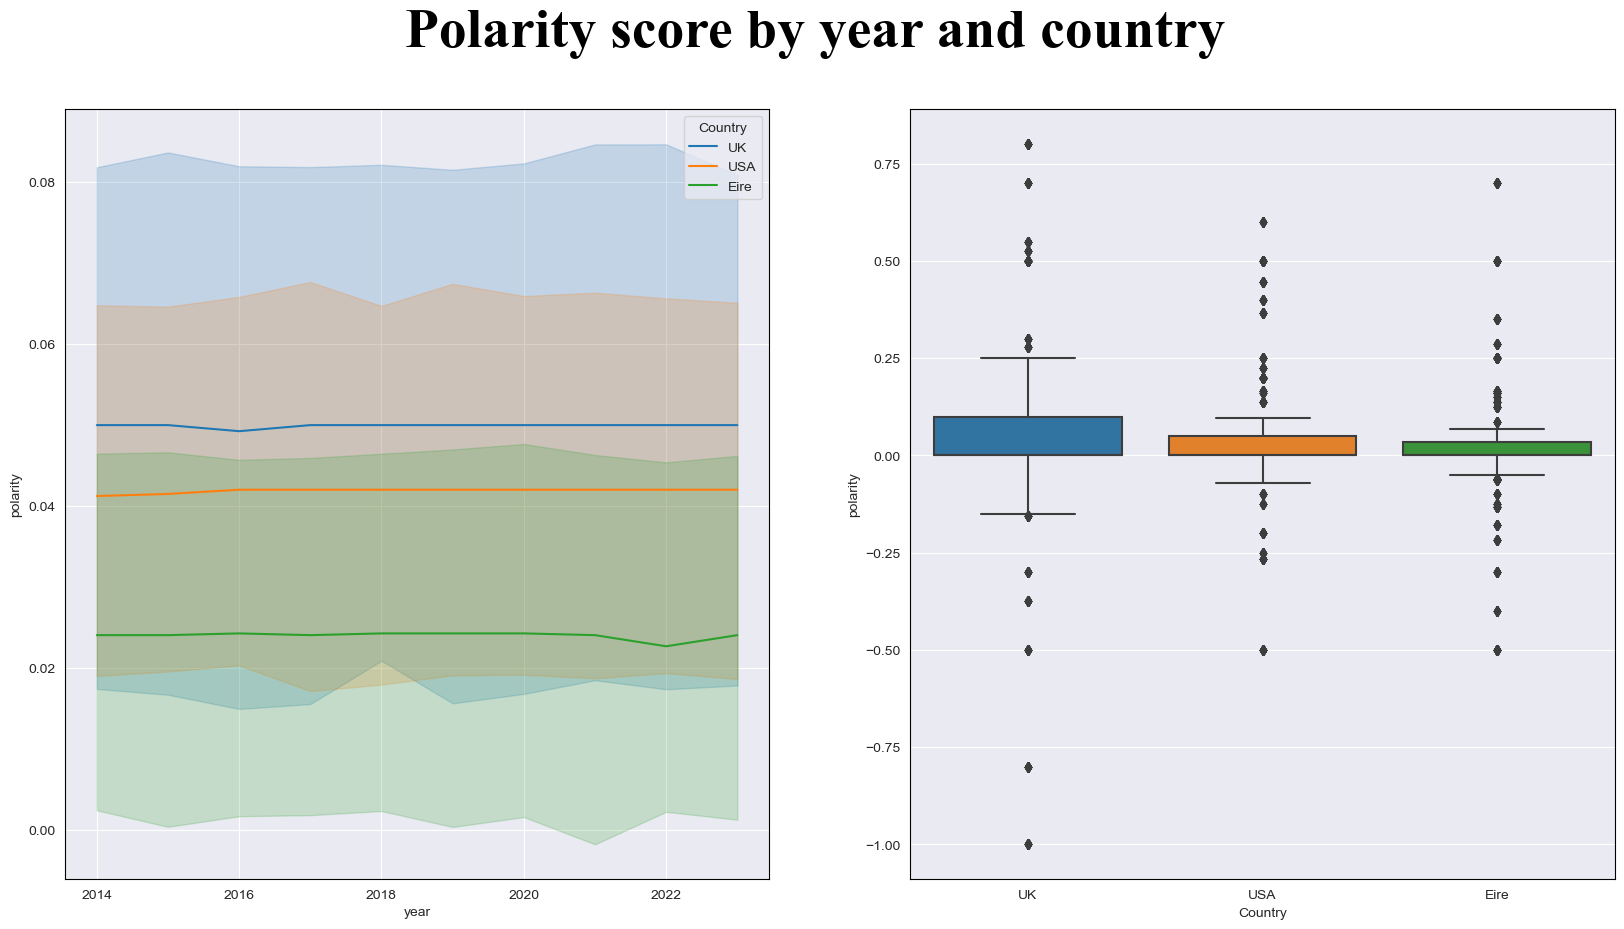

In [41]:
headlines = headlines.sort_values('year')
fig, ax = plt.subplots(1,2,figsize=(20, 10))
fig.suptitle('Polarity score by year and country',color= "black", weight='bold',fontname="Times New Roman",fontsize=40)
sns.lineplot(data = headlines,x='year',y='polarity',hue='Country',ax=ax[0])
sns.boxplot(y= 'polarity',data=headlines,x='Country',ax=ax[1])

In [42]:
for country in ['Eire','USA', 'UK']:
    var = headlines[headlines['Country']==country]
    var = var[['polarity']]
    print(f'Country: {country}')
    print(var.describe())
    print('-------------------')

Country: Eire
          polarity
count  1940.000000
mean      0.023965
std       0.158473
min      -0.500000
25%       0.000000
50%       0.000000
75%       0.033333
max       0.700000
-------------------
Country: USA
          polarity
count  1603.000000
mean      0.041833
std       0.153248
min      -0.500000
25%       0.000000
50%       0.000000
75%       0.050000
max       0.600000
-------------------
Country: UK
          polarity
count  2000.000000
mean      0.049865
std       0.237972
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.100000
max       0.800000
-------------------


polarity scores seems to be around 0 for all three countries, In order to test if the scores are actually equivalent we can run a hypotesis test as follow:

H0 : population means are equal :     μ1 = μ2 = μ3 

H1 : population means are not equal 

First we check for nomality...

p value: 0.0
stat value: 0.7472567558288574
p value: 0.0
stat value: 0.7560168504714966
p value: 2.0038568039844884e-43
stat value: 0.7582640647888184
p value: 0.0
stat value: 0.7553225755691528


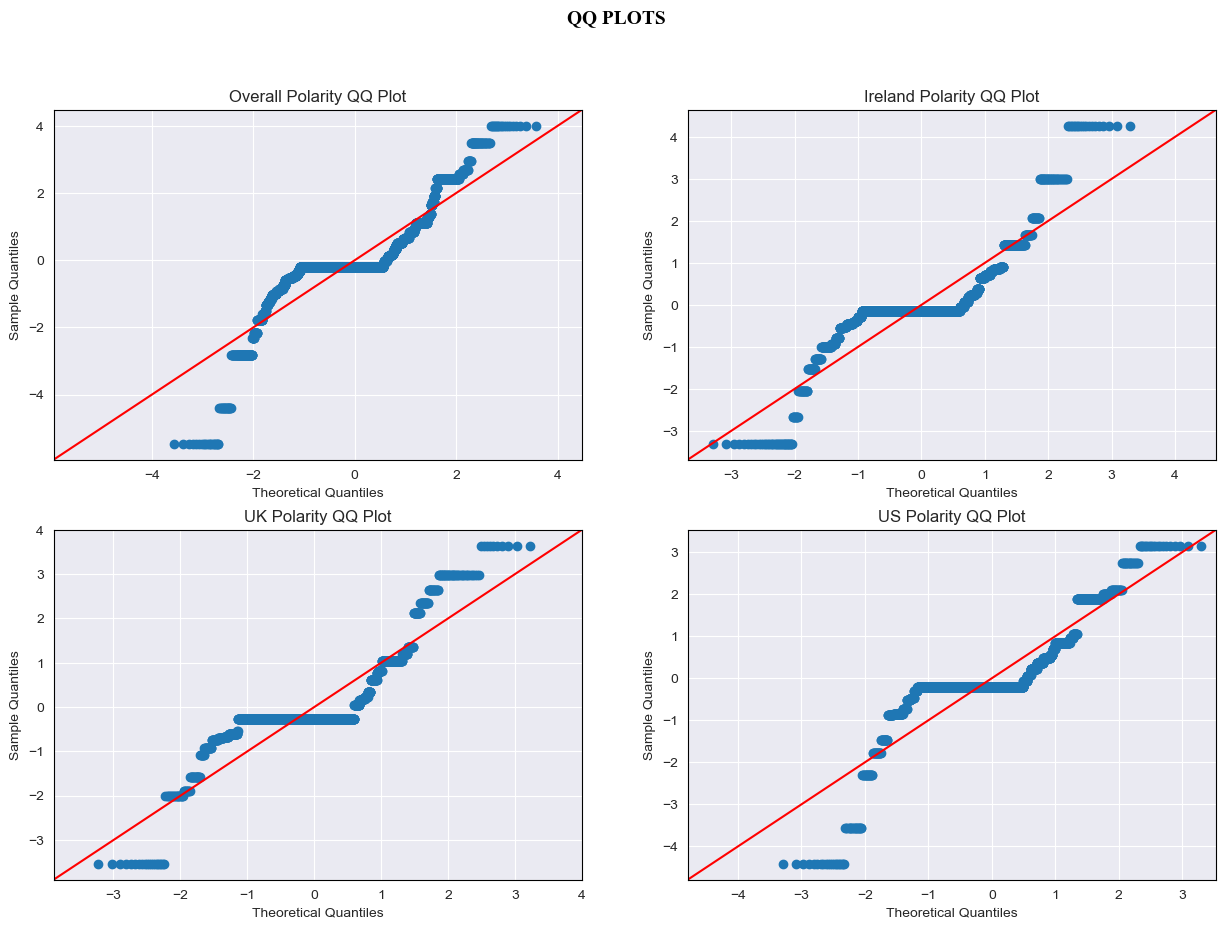

In [43]:
_E = headlines[headlines['Country']=='Eire']
_Uk = headlines[headlines['Country']=='USA'] 
_US = headlines[headlines['Country']=='UK']

fig, ax = plt.subplots(2,2,figsize=(15, 10))
fig.suptitle('QQ PLOTS',color= "black", weight='bold',fontname="Times New Roman",fontsize=14)
fig = sm.qqplot(headlines['polarity'], line='45' , fit = True,ax=ax[0,0])
ax[0, 0].set_title('Overall Polarity QQ Plot')
fig = sm.qqplot(_E['polarity'], line='45' ,fit = True, ax=ax[0,1])
ax[0, 1].set_title('Ireland Polarity QQ Plot')
fig = sm.qqplot(_Uk['polarity'], line='45' ,fit = True, ax=ax[1,0])
ax[1, 0].set_title('UK Polarity QQ Plot')
fig = sm.qqplot(_US['polarity'], line='45' ,fit = True, ax=ax[1,1])
ax[1, 1].set_title('US Polarity QQ Plot')

for x in [headlines['polarity'],_E['polarity'],_Uk['polarity'],_US['polarity']]:
    stat, p = shapiro(x)
    print('p value: ' + str(p))
    print('stat value: ' + str(stat))

Since the data is not normally distributed: non parametric tests will be run

since the test will be non parametric the hypotesis will get formulated again taking in consideration median instead of mean as follow:  

H0 : population medians are equal :     median 1 = median 2 = median 3 
 
H1 : population medians are not equal : at least one median is different from one of the other medians

the p value chosen is 0.05

In [44]:
stats.kruskal(_E['polarity'],_Uk['polarity'],_US['polarity'])

KruskalResult(statistic=28.236279269154878, pvalue=7.388731108648715e-07)

as per result we not accept H0:   Kruskal wallis test proved the 3 samples are not equal in terms of medians

what about comparing UK and Ireland? as the 2 countries are more similar between one another than with the US

as samples are not normal I will use another non parametric test: Mann–Whitney U as the samples are independent:

H0 : Ireland median = Uk median

H1 : Ireland median is not equal to Uk median

p value = 0.05

In [45]:
stats.mannwhitneyu(_E['polarity'],_Uk['polarity'])

MannwhitneyuResult(statistic=1482963.5, pvalue=0.008327427259926483)

result

we reject H0: the distributions underlying UK and Ireland polarity scores are not equal

## Topic understanding

In [46]:
#setting stopwords

import string
stopwords = set(stopwords.words("english"))
stopwords.add('housing')
stopwords.add('house')
stopwords.add('ireland')
stopwords.add('usa')
stopwords.add('uk')
stopwords.add('us')
stopwords.add(' ')
stopwords.add('')
stopwords.add('home')
stopwords.add('homes')
stopwords.add('irish')


#### tokenize

In [47]:
def tk(x):
    text = x.str.cat(sep=' ')
    tokens = nltk.word_tokenize(text)
    tokens = [''.join(char for char in item if char not in string.punctuation) for item in tokens]
    tokens = [x.lower() for x in tokens]
    filtered_token = []
    for w in tokens:
        if w not in stopwords:
          filtered_token.append(w)
    return filtered_token

eire = tk(_E['title'])
USA = tk(_US['title'])
uk = tk(_Uk['title'])

#### frequency plot

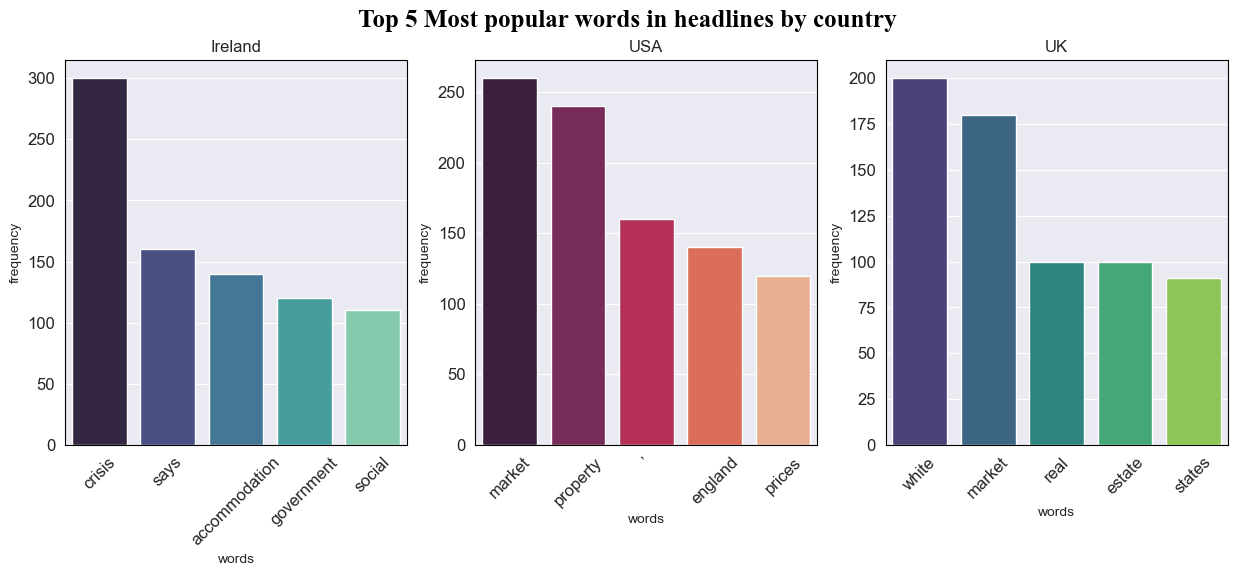

In [48]:
from collections import Counter
fig, ax = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle('Top 5 Most popular words in headlines by country',fontsize=18,color= "black", weight='bold',fontname="Times New Roman")
a = Counter(eire)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0 ,x='index',data=a.nlargest(5, 0), ax=ax[0], palette= 'mako')
ax[0].set_title('Ireland')
ax[0].set(xlabel='words', ylabel='frequency')
ax[0].tick_params(axis='x',labelrotation=45, labelsize=12)
ax[0].tick_params(labelsize=12)
a = Counter(USA)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0),ax=ax[1], palette= 'rocket')
ax[1].set_title('USA')
ax[1].set(xlabel='words', ylabel='frequency')
ax[1].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[1].tick_params(labelsize=12)
a = Counter(uk)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0), ax=ax[2], palette= 'viridis')
ax[2].set_title('UK')
ax[2].set(xlabel='words', ylabel='frequency')
ax[2].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[2].tick_params(labelsize=12)


#### plotting polarity scores

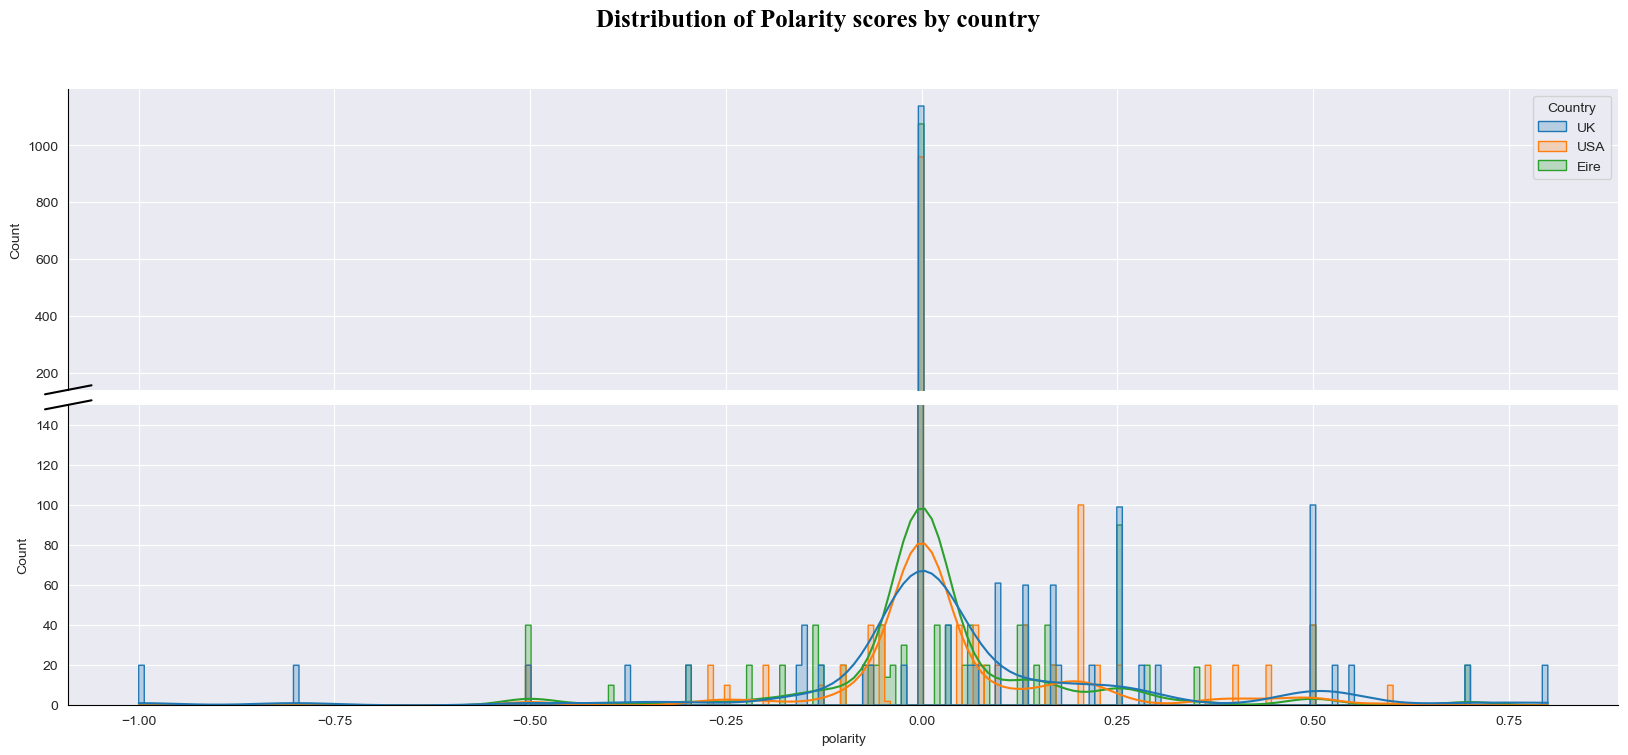

In [49]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.05},figsize=(20, 8))
f.suptitle('Distribution of Polarity scores by country',fontsize=18,color= "black", weight='bold',fontname="Times New Roman")
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_top, element="step")
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_bottom, element="step")
ax_top.set_ylim(bottom=140) 
ax_bottom.set_ylim(0,150)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 

ax_bottom.legend_.remove()
plt.show()

#### Topic modelling using LDA

In [50]:
Ire = headlines[['title','media','Country','year']]
Ire = Ire[Ire['Country']=='Eire']

In [51]:
Ire.head()

,title,media,Country,year
1939,Council tenants allowed rent out rooms for up ...,Independent.ie,Eire,2014
1938,Oliver Mangan: Sweet spot means we can tackle ...,Irish Examiner,Eire,2014
1937,Housing crisis exposé: Sky-high rents but smel...,Independent.ie,Eire,2014
1936,Former High Court master appeals for big bang ...,Irish Examiner,Eire,2014
1934,"Wooden homes a fix for the housing crisis, Dai...",Irish Mirror,Eire,2014


function for checking if text is a word 

In [52]:
def is_letter_only(word):
    for char in word:
        if not char.isalpha():
            return False
    return True

lemmatization and data cleaning on news titles

In [53]:
import nltk
nltk.download('omw-1.4')
  
data_cleaned = []
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

for doc in Ire['title']:
    doc = doc.lower()
    doc_cleaned = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if is_letter_only(word) and word not in stopwords)
    data_cleaned.append(doc_cleaned)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [54]:
data_cleaned

['council tenant allowed rent room year tax',
 'oliver sweet spot mean tackle',
 'crisis rent smelly damp',
 'former high court master appeal big bang approach',
 'wooden fix dail committee told',
 'eleven active nursing converted accommodation',
 'planning acquiring land slowing social build',
 'rise body last year saw almost social',
 'spending lower planned first four month',
 'paul fix need make use',
 'residential construction cost study published',
 'nurse caught within six month many think',
 'modular held site warns state architect',
 'martin leahy singing tune crisis',
 'former high court master appeal big bang approach',
 'shortage threatening state body',
 'medtech firm dexcom confident expansion',
 'ukrainian use former athlone friary',
 'strengthening social fabric prevent nimbyism',
 'retrofit house increasing standard set government target',
 'high court challenge brought permission north dublin',
 'fleeing violence find threatened activist',
 'national acclaim major off

count vectorizer with max df = 0.5 and no limit in number of features as dataset is small enough to be processed in full

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

# Declare and create an array (count_vector) by calling a method CountVectorizer()
count_vector = CountVectorizer(stop_words = "english", max_features = None, max_df = 0.5, min_df = 2)
data = count_vector.fit_transform(data_cleaned)

#### LDA modelling

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

# Declare and initialise a variable t
t = 5

# Declare and initialise an object 'lda' by calling a method LatentDirichletAllocation()
lda = LatentDirichletAllocation(n_components = t, learning_method = 'batch', random_state = 42)

# Train the model
lda.fit(data)

# Print all lda components
print(lda.components_)

# Get all feature names
terms = count_vector.get_feature_names_out()

[[20.19997753  0.20000465 60.29883479 ...  0.20000931  0.20000362
  10.19998048]
 [ 0.20000606  0.2000052  20.12800082 ... 20.20287784  0.20000393
   0.20000508]
 [ 0.20000536 20.1999806   0.20001858 ...  0.20000883  0.20000353
   0.20000449]
 [ 0.20000529  0.20000476 20.15193544 ...  0.2000086  20.19998537
   0.20000465]
 [ 0.20000577  0.2000048  40.22121038 ... 30.19709542  0.20000355
   0.2000053 ]]


#### printing discovered topics

In [57]:
for topic_idx, topic in enumerate(lda.components_):
        print("Topic {}:" .format(topic_idx))
        print(" ".join([terms[i] for i in topic.argsort()[-10:]]))

Topic 0:
human planning right body need builder land state accommodation crisis
Topic 1:
council use claim tax crisis office rent rise month say
Topic 2:
set market le government galway migrant inflation price new house
Topic 3:
ni number social homeless time ban eviction crisis say government
Topic 4:
want project launch people high accommodation emergency minister building social


#### Creating word cloud from feature names in count vectorizer

In [58]:
corpus = Ire['title']
vectorizer = CountVectorizer(
                             stop_words = 'english')
X = vectorizer.fit_transform(corpus)

# Display the feature names in sorted order
topic = vectorizer.get_feature_names_out()
_topic = [lemmatizer.lemmatize(word) for word in topic if is_letter_only(word)]
print(_topic)

['abbreviation', 'acclaim', 'accommodate', 'accommodation', 'acquiring', 'active', 'activist', 'activity', 'address', 'affordability', 'affordable', 'agenda', 'aim', 'allowed', 'amid', 'anger', 'antrim', 'apartment', 'appeal', 'apple', 'approach', 'april', 'architect', 'asylum', 'athlone', 'available', 'ban', 'bang', 'begin', 'belfast', 'big', 'bite', 'block', 'body', 'body', 'bord', 'branded', 'break', 'bringing', 'brink', 'broin', 'broken', 'brought', 'bubble', 'budgeting', 'builder', 'builder', 'building', 'building', 'build', 'built', 'bulletin', 'burst', 'cabin', 'cairn', 'capitalism', 'case', 'caught', 'centre', 'challenge', 'change', 'changed', 'charity', 'checking', 'choked', 'city', 'claim', 'clare', 'clause', 'climate', 'commercial', 'commissioner', 'committee', 'community', 'community', 'companionship', 'company', 'competitiveness', 'completion', 'complex', 'concern', 'concern', 'condition', 'conference', 'confident', 'consequence', 'consider', 'considering', 'constantly', '

plotting Word cloud 

abbreviation acclaim accommodate accommodation acquiring active activist activity address affordability affordable agenda aim allowed amid anger antrim apartment appeal apple approach april architect asylum athlone available ban bang begin belfast big bite block body body bord branded break bringing brink broin broken brought bubble budgeting builder builder building building build built bulletin burst cabin cairn capitalism case caught centre challenge change changed charity checking choked city claim clare clause climate commercial commissioner committee community community companionship company competitiveness completion complex concern concern condition conference confident consequence consider considering constantly construction continue control conversation converted cork cost council court crisis current dad dail damp debate decade declined delayed delay deliver derelict design development dexcom different dip directive disappointed discus disgrace divisive document doe dominate

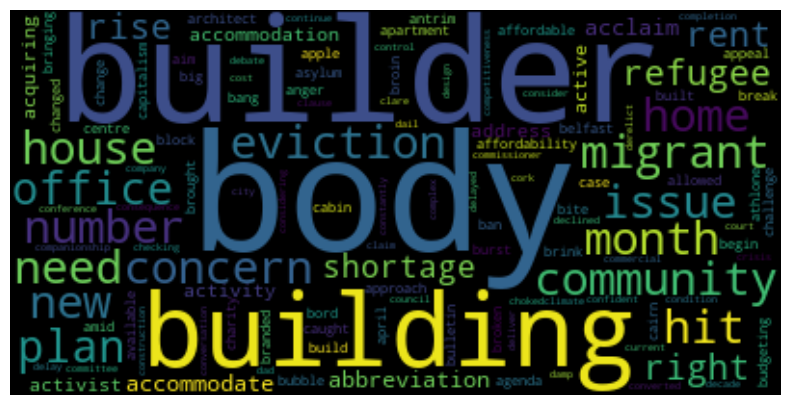

In [59]:
from wordcloud import WordCloud
text = ' '.join(_topic)

print(text)
# define some text to generate word cloud from

# create a word cloud object with default settings
wordcloud = WordCloud().generate(text)

# display the generated word cloud
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()